In [13]:
##################################################
## Imports
##################################################
from platform import python_version
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import cv2

import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import plot_model
# set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python 
from torchvision import datasets, transforms
import tensorflow_datasets as tfds
import librosa as lb
import audiomentations as augs
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import warnings
warnings.filterwarnings("ignore") #ignore warnings

# print system information
print('Python Version           : ', python_version())
print('TensorFlow Version       : ', tf.__version__)
print('Librosa Version          : ', lb.__version__)
print('Audiomentations Version  : ', augs.__version__)


Python Version           :  3.10.12
TensorFlow Version       :  2.17.0
Librosa Version          :  0.10.2.post1
Audiomentations Version  :  0.37.0


In [16]:
########################################################################################
# system constants
########################################################################################

SC = {
    'AUDIO_DATA_DIRECTORY': "C:/Users/regin/Documents/SIT374/train_data/b3",
    'CACHE_DIRETORY': "src/Prototypes/engine/AddCAMtoMelSpec/pipeline_cache",

    'AUDIO_CLIP_DURATION': 5, # seconds 
    'AUDIO_NFFT': 2048,
    'AUDIO_WINDOW': None,
    'AUDIO_STRIDE': 200,
    'AUDIO_SAMPLE_RATE': 48000,
    'AUDIO_MELS': 260,
    'AUDIO_FMIN': 20,
    'AUDIO_FMAX': 13000,
    'AUDIO_TOP_DB': 80,

    'MODEL_INPUT_IMAGE_WIDTH': 260,
    'MODEL_INPUT_IMAGE_HEIGHT': 260,
    'MODEL_INPUT_IMAGE_CHANNELS': 3,

    'USE_DISK_CACHE': True,
    'SAMPLE_VARIANTS': 20,
    'CLASSIFIER_BATCH_SIZE': 16,
    'MAX_EPOCHS': 30,
}

# Class Activation Map
class activation mapping (CAM)  utilize the responses of a convolutional layer for explanations. CAM linearly combine activation maps to produce visual explanation maps.
CAM can improve the interpretability of neural networks, by investigating the weights of the area in the image that influence the model's prediction. 


Before showing the CAM layer, the process of traioning data follows the usual flow of deep learning with CNN: first we will have a CNN sequential model that collects features from the training data, then each iteration is optimized by calculating the loss. The loss is minimised using RMSProp or other optimizer with a specific learning rate. Then at the last layer, the weights and features activated are taken into account, where we take the dot product as class activation. This class activation values can show us the area that the convolution layer considered important.

## Initialization

### Data Loading
First we must start from loading the dataset. We will be using the sound data of three animals to start: 'Vulpes vulpes', 'Corvus mellori', 'Rattus norvegicus'

In [69]:
import tensorflow as tf
import os
import glob
from PIL import Image

#show directory location
print(os.getcwd())

# Define the directories you want to load
species_to_load = ['Vulpes vulpes', 'Corvus mellori', 'Rattus norvegicus']

def load_selected_species(data_dir, species_list, file_format='mp3', sample_rate=SC['AUDIO_SAMPLE_RATE']):
    audio_data = []
    labels = []

    for species in species_list:
        species_dir = os.path.join(data_dir, species)
        
        # Get all audio file paths in the species directory
        for audio_file in os.listdir(species_dir):
            if audio_file.endswith(file_format):
                # Load the audio file using librosa
                file_path = os.path.join(species_dir, audio_file)
                audio, sr = lb.load(file_path, sr=sample_rate, mono=True)
                audio_data.append(audio)
                labels.append(species)  # You can map this to a numeric label if needed
    
    return audio_data, labels

# Load audio  from the selected species
audio_data, labels = load_selected_species(SC['AUDIO_DATA_DIRECTORY'], species_to_load)

# Display the number of images loaded from each species
print(f"Number of sounds loaded: {len(audio_data)}")
print(f"Labels: {set(labels)}")

c:\Users\regin\Documents\SIT374\Project-Echo\src\Prototypes\engine\AddCAMtoMelSpec
Number of sounds loaded: 235
Labels: {'Vulpes vulpes', 'Corvus mellori', 'Rattus norvegicus'}


In [ ]:
def paths_and_labels_to_dataset(image_paths, labels, num_classes):
    path_ds = tf.data.Dataset.from_tensor_slices(image_paths)
    label_ds = dataset_utils.labels_to_dataset(
        labels, 
        'categorical', 
        num_classes)
    zipped_path_ds = tf.data.Dataset.zip((path_ds, label_ds))
    return zipped_path_ds

def create_datasets(audio_files, train_split=0.7, val_split=0.2):
    file_paths, labels, class_names = dataset_utils.index_directory(
            audio_files,
            labels="inferred",
            formats=('.ogg','.mp3','.wav','.flac'),
            class_names=None,
            shuffle=True,
            seed=42,
            follow_links=False)

    dataset = paths_and_labels_to_dataset(
        image_paths=file_paths,
        labels=labels,
        num_classes=len(class_names))
    
    # Calculate the size of the dataset
    dataset_size = len(dataset)
    
    # Calculate the number of elements for each dataset split
    train_size = int(train_split * dataset_size)
    val_size = int(val_split * dataset_size)
    test_size = dataset_size - train_size - val_size

    # Split the dataset
    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size + val_size).take(test_size)
    
    return train_ds, val_ds, test_ds, class_names


# enable this cache if using large audio files, and lots of available RAM
def python_load_and_decode_file(sample, label):
    
    tmp_audio_t = None
    
    with open(sample, 'rb') as file:

        # Load the audio data with librosa
        tmp_audio_t, _ = lb.load(file, sr=SC['AUDIO_SAMPLE_RATE'])
        
        # cast and keep right channel only
        if tmp_audio_t.ndim == 2 and tmp_audio_t.shape[0] == 2:
            tmp_audio_t = tmp_audio_t[1, :]
        
        # cast and keep right channel only
        tmp_audio_t = tmp_audio_t.astype(np.float32)
                
        assert(tmp_audio_t is not None)
        assert(isinstance(tmp_audio_t, np.ndarray))
    
    sample = tmp_audio_t
            
    return sample, label

### Audio Preprocessing Functions
Next, we define the functions we need


#### Cut Audio sample to SC['AUDIO_CLIP_DURATION']
tensorflow_load_random_subsection() is designed to randomly extract a fixed-length subsection from an audio sample using TensorFlow. If the audio sample is shorter than the required duration, it pads the sample with silence to meet the fixed length.

In [70]:
import tensorflow as tf

def tensorflow_load_random_subsection(sample, label):
    # Get duration and sample rate from SC dictionary
    duration_secs = SC['AUDIO_CLIP_DURATION']
    sample_rate = SC['AUDIO_SAMPLE_RATE']
    
    # Determine the audio file's duration in seconds
    audio_duration_secs = tf.shape(sample)[0] / sample_rate
    
    if audio_duration_secs > duration_secs:
        # Calculate the starting point of the subsection
        max_start = tf.cast(audio_duration_secs - duration_secs, tf.float32)
        start_time_secs = tf.random.uniform((), 0.0, max_start, dtype=tf.float32)
        
        start_index = tf.cast(start_time_secs * sample_rate, dtype=tf.int32)
        end_index = tf.cast(start_index + tf.cast(duration_secs, tf.int32) * sample_rate, tf.int32)
        
        # Load the random subsection
        subsection = sample[start_index : end_index]
    
    else:
        # Pad the subsection with silence if it's shorter than the required duration
        padding_length = duration_secs * sample_rate - tf.shape(sample)[0]
        padding = tf.zeros([padding_length], dtype=sample.dtype)
        subsection = tf.concat([sample, padding], axis=0)

    return subsection, label


In [82]:
def tensorflow_output_shape_setter(sample):
    sample.set_shape([SC['MODEL_INPUT_IMAGE_WIDTH'], SC['MODEL_INPUT_IMAGE_HEIGHT'], SC['MODEL_INPUT_IMAGE_CHANNELS']])
    # label.set_shape([set(labels),]) 
    return sample

#### Audio Augmentations
This code applies augmentation to the data. p=0.2 means the augmentations are applied randomly, each augmentation has 20% chance of being applied. (changes: for Audiomentation 0.33.0, the element in Shift is min_shift and max_shift, previous version uses min_fraction and max_fraction)

In [71]:
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift

# Audio augmentation pipeline
def python_audio_augmentations(sample):
    
    augmentations = Compose([
        # Add Gaussian noise with a random amplitude to the audio
        # This can help the model generalize to real-world scenarios where noise is present
        AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.2),

        # Time-stretch the audio without changing its pitch
        # This can help the model become invariant to small changes in the speed of the audio
        TimeStretch(min_rate=0.8, max_rate=1.25, p=0.2),

        # Shift the pitch of the audio within a range of semitones
        # This can help the model generalize to variations in pitch that may occur in real-world scenarios
        PitchShift(min_semitones=-4, max_semitones=4, p=0.2),

        # Shift the audio in time by a random fraction
        # This can help the model become invariant to the position of important features in the audio
        Shift(min_shift=-0.5, max_shift=0.5, p=0.2),
    ])
    
    # apply audio augmentation to the clip
    # note: this augmentation is NOT applied in the test and validation pipelines
    augmented_sample = augmentations(samples=sample, sample_rate=SC['AUDIO_SAMPLE_RATE'])
    
    return augmented_sample

#### Convert to Mel Spectrogram
This function takes an audio signal (sample) and converts it into a mel-spectrogram. A mel-spectrogram is a visual representation of the audio, showing how the frequencies change over time. It is useful because machine learning models (like CNNs) often work better with images, and a mel-spectrogram converts the audio into an image-like format.

In [72]:
### Convert to Mel Spectrogram
import librosa
import numpy as np

# Simplified function to generate a mel-spectrogram
def python_dataset_melspectro_pipeline(sample):
    # # Convert TensorFlow tensor to NumPy array if necessary
    # if isinstance(sample, tf.Tensor):
    #     sample = sample.numpy()
        
    # Compute the mel-spectrogram
    image = librosa.feature.melspectrogram(
        y=sample, 
        sr=SC['AUDIO_SAMPLE_RATE'], 
        n_fft=SC['AUDIO_NFFT'], 
        hop_length=SC['AUDIO_STRIDE'], 
        n_mels=SC['AUDIO_MELS'],
        fmin=SC['AUDIO_FMIN'],
        fmax=SC['AUDIO_FMAX'],
        win_length=SC['AUDIO_WINDOW'])

    # Convert the mel-spectrogram to decibel scale
    image = librosa.power_to_db(image, top_db=SC['AUDIO_TOP_DB'], ref=1.0)

    # Calculate the expected number of samples in a clip
    expected_clip_samples = int(SC['AUDIO_CLIP_DURATION'] * SC['AUDIO_SAMPLE_RATE'] / SC['AUDIO_STRIDE'])

    # Swap axes and clip to expected samples to avoid rounding errors
    image = np.moveaxis(image, 1, 0)
    sample = image[0:expected_clip_samples, :]

    return sample

##### Melspectrogram Image preprocessing
Once the mel-spectrogram is generated, this function reshapes the spectrogram to match the input requirements of models like pre-trained CNNs (Convolutional Neural Networks). Many pre-trained models expect inputs to have 3 channels (like RGB images), even though the mel-spectrogram only has 1 channel (grayscale). This function expands the mel-spectrogram into 3 channels.

In [73]:
import tensorflow as tf

# Simplified function to reshape the mel-spectrogram image
def tensorflow_reshape_image_pipeline(sample):
    # Reshape into standard 3 channels to add the color channel
    image = tf.expand_dims(sample, -1)

    # Repeat to get 3 color channels as most pre-trained models expect
    image = tf.repeat(image, SC['MODEL_INPUT_IMAGE_CHANNELS'], axis=2)

    # Calculate the expected number of samples in a clip
    expected_clip_samples = int(SC['AUDIO_CLIP_DURATION'] * SC['AUDIO_SAMPLE_RATE'] / SC['AUDIO_STRIDE'])

    # Ensure the image has the correct shape
    image = tf.ensure_shape(image, [expected_clip_samples, SC['AUDIO_MELS'], SC['MODEL_INPUT_IMAGE_CHANNELS']])

    # Resize the image to match model input size using LANCZOS5 interpolation
    image = tf.image.resize(image, (SC['MODEL_INPUT_IMAGE_WIDTH'], SC['MODEL_INPUT_IMAGE_HEIGHT']), 
                            method=tf.image.ResizeMethod.LANCZOS5)

    # Rescale image to range [0, 1]
    image = image - tf.reduce_min(image)
    sample = image / (tf.reduce_max(image) + 0.0000001)

    return sample


##### Image Augmentation
perform random rotation to further augment the data (changes: previous version uses tensorflow-addons, but it is deprecated and can no longer provide support) (NOT USED)

In [89]:
import tensorflow as tf
import math

# Simplified Image Augmentation Pipeline
def tensorflow_image_augmentations(sample):
# Define the random rotation layer (rotates between -2 and 2 degrees)
    random_rotate = tf.keras.layers.RandomRotation(
        factor=(-2/180.0, 2/180.0),  # Rotation factor (in radians)
        fill_mode='nearest'  # Filling the gaps created by rotation
    )
    
    # Apply the rotation
    rotated_image = random_rotate(tf.expand_dims(sample, 0))  # Add batch dimension
    return tf.squeeze(rotated_image, axis=0) #remove batch dimension


### Create Melspectrograms
Overall Workflow:
1. Load a random subsection of the audio using tensorflow_load_random_subsection.
2. Apply audio augmentations with python_audio_augmentations (optional for augmentation).
3. Convert the audio to a mel-spectrogram using python_dataset_melspectro_pipeline.
4. Reshape the mel-spectrogram into the correct format for the model using tensorflow_reshape_image_pipeline.
5. Apply any final image augmentations using tensorflow_image_augmentations (optional for augmentation).

In [154]:
import tensorflow as tf

def create_mel_spectrogram_dataset(audio_data, labels):
    """
    Converts audio data and labels into a TensorFlow dataset of mel-spectrograms and corresponding labels.

    Args:
        audio_data: List or array of audio samples.
        labels: List or array of corresponding labels.

    Returns:
        A TensorFlow dataset where each element is a tuple (mel-spectrogram, label).
    """

    # Lists to hold the processed mel-spectrograms and labels
    all_mel_spectrograms = []
    all_labels = []

    # Loop over the audio data and labels to generate mel-spectrograms
    for i, (audio_sample, label) in enumerate(zip(audio_data, labels)):
        
        # Step 1: Extract a random subsection of the audio
        subsection, label = tensorflow_load_random_subsection(audio_sample, label)

        # Convert augmented audio to NumPy array if it's a TensorFlow tensor
        if isinstance(subsection, tf.Tensor):
            subsection = subsection.numpy()

        # Step 2: Apply audio augmentations (optional)
        augmented_audio = python_audio_augmentations(subsection)

        # Step 3: Convert the audio to a mel-spectrogram
        mel_spectrogram = python_dataset_melspectro_pipeline(augmented_audio)

        # Step 4: Reshape the mel-spectrogram into the required shape for the model
        reshape_spectrogram = tensorflow_reshape_image_pipeline(mel_spectrogram)

        #step5: Augment the image
        augment_spectrogram = tensorflow_image_augmentations(reshape_spectrogram)

        # step 6 tensorflow_output_shape_setter
        final_mel_spectrogram = tensorflow_output_shape_setter(augment_spectrogram)

        # Ensure mel-spectrogram is converted to NumPy array for dataset creation
        all_mel_spectrograms.append(final_mel_spectrogram.numpy())  # Convert to NumPy array
        all_labels.append(label)  # Append the label
    
    # Convert the list of mel-spectrograms and labels into tensors
    all_mel_spectrograms = tf.convert_to_tensor(all_mel_spectrograms)
    all_labels = tf.convert_to_tensor(all_labels)

    # Ensure dimensions match: there should be 235 samples (sounds) and 235 labels
    print(f"Mel-spectrograms loaded: {all_mel_spectrograms.shape[0]}")
    print(f"Labels loaded: {all_labels.shape[0]}")
    

    return all_mel_spectrograms, all_labels

# Example usage:
# Assuming audio_data contains the raw audio data and labels is a list of labels
all_mel_spectrograms, all_labels = create_mel_spectrogram_dataset(audio_data, labels)

# Create a TensorFlow dataset from the mel-spectrograms and labels
dataset = tf.data.Dataset.from_tensor_slices((all_mel_spectrograms, all_labels))

# Inspect the dataset
for mel_spectrogram, label in dataset.take(5):
    print(f'Mel-spectrogram shape: {mel_spectrogram.shape}')
    print(f'Label: {label}')


Mel-spectrograms loaded: 235
Labels loaded: 235


Sample info: (260, 260, 3), 
Label info: () 
b'Vulpes vulpes'


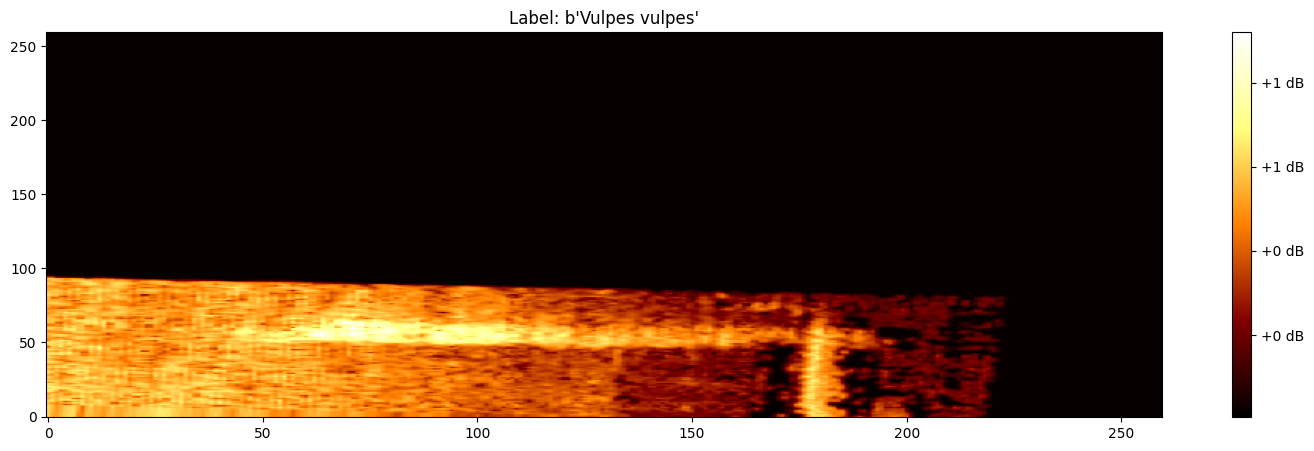

Sample info: (260, 260, 3), 
Label info: () 
b'Vulpes vulpes'


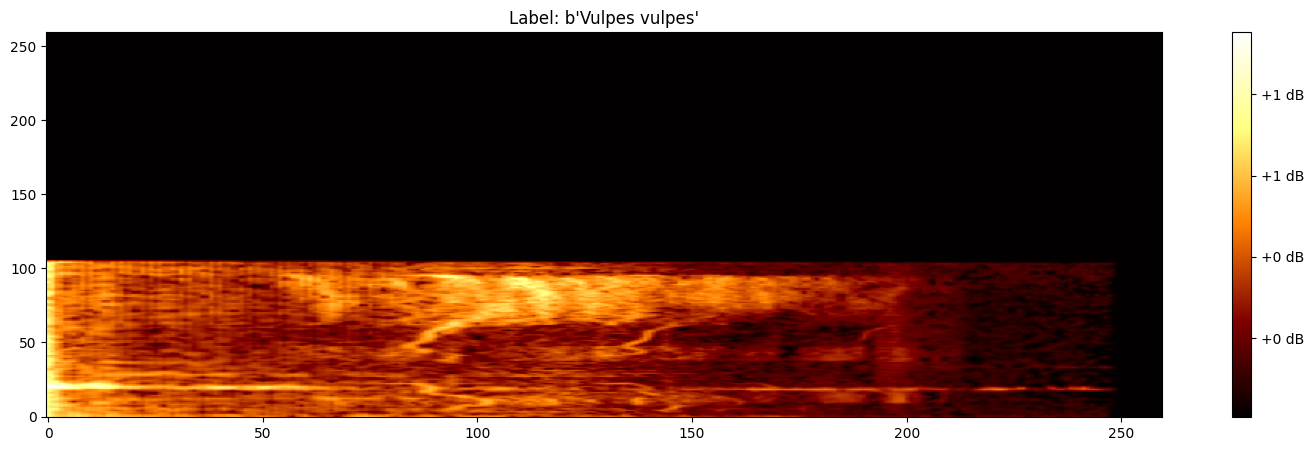

Sample info: (260, 260, 3), 
Label info: () 
b'Vulpes vulpes'


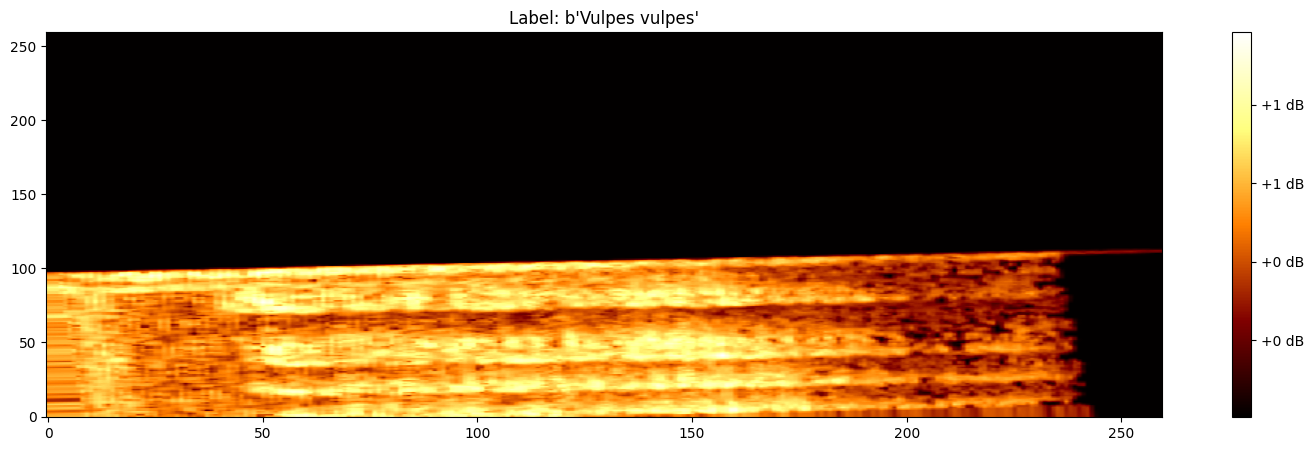

Sample info: (260, 260, 3), 
Label info: () 
b'Vulpes vulpes'


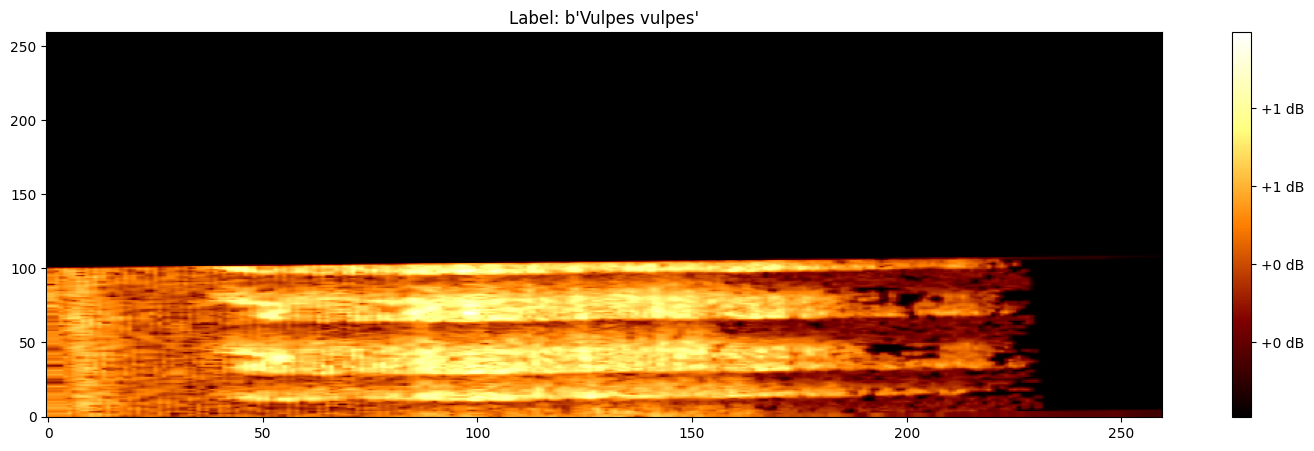

Sample info: (260, 260, 3), 
Label info: () 
b'Vulpes vulpes'


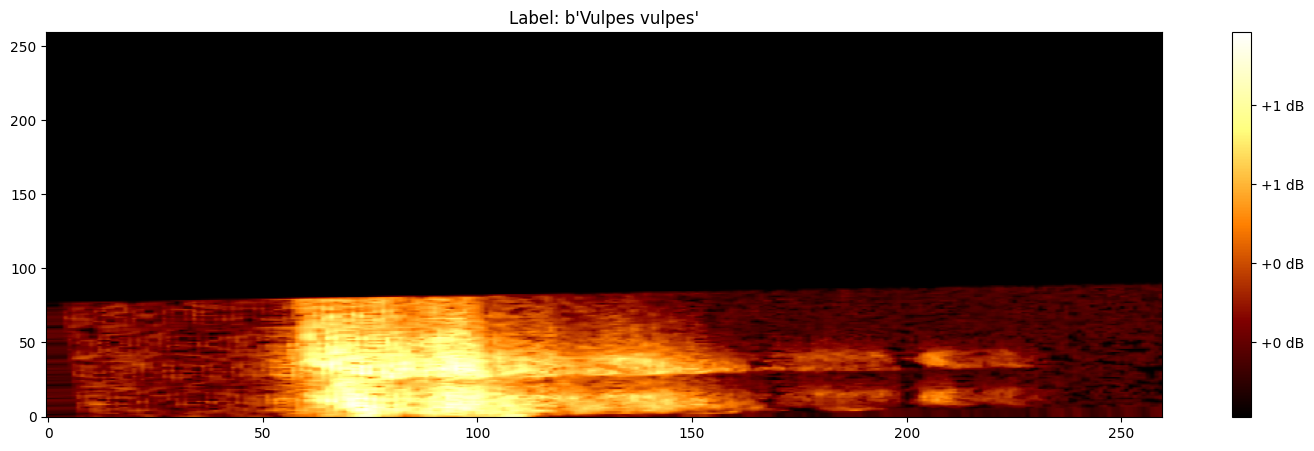

Sample info: (260, 260, 3), 
Label info: () 
b'Vulpes vulpes'


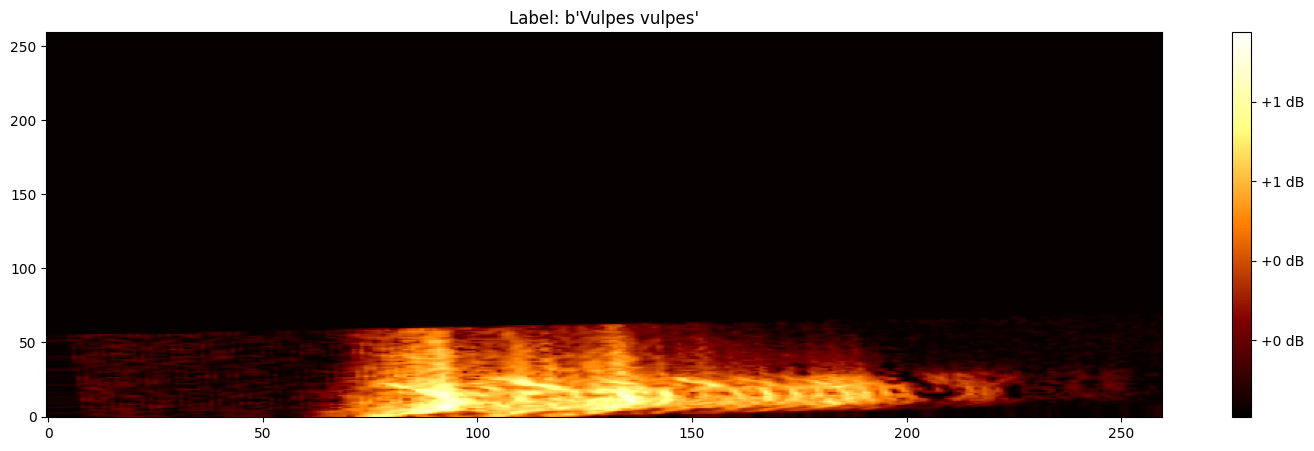

Sample info: (260, 260, 3), 
Label info: () 
b'Vulpes vulpes'


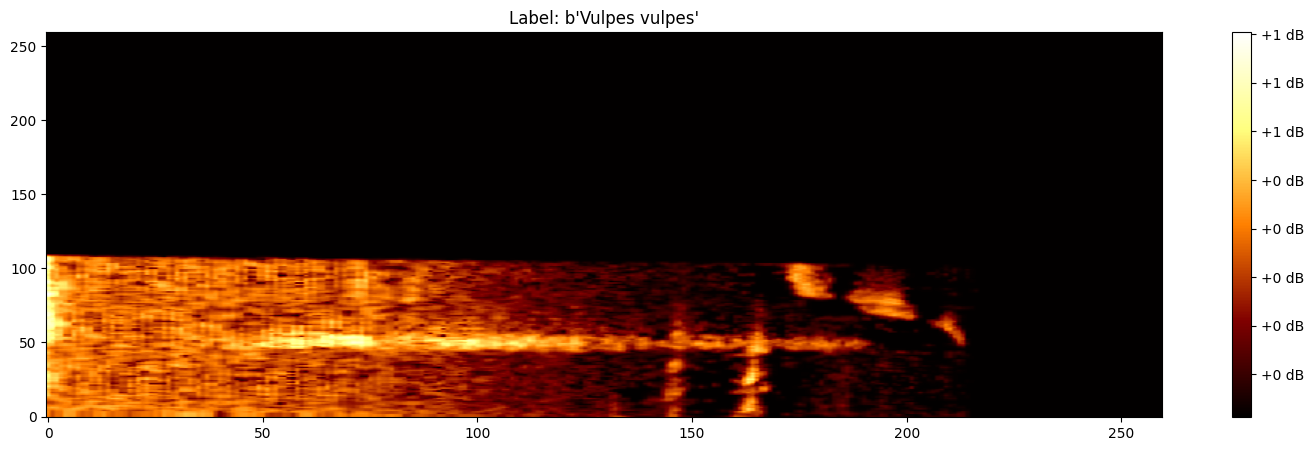

Sample info: (260, 260, 3), 
Label info: () 
b'Vulpes vulpes'


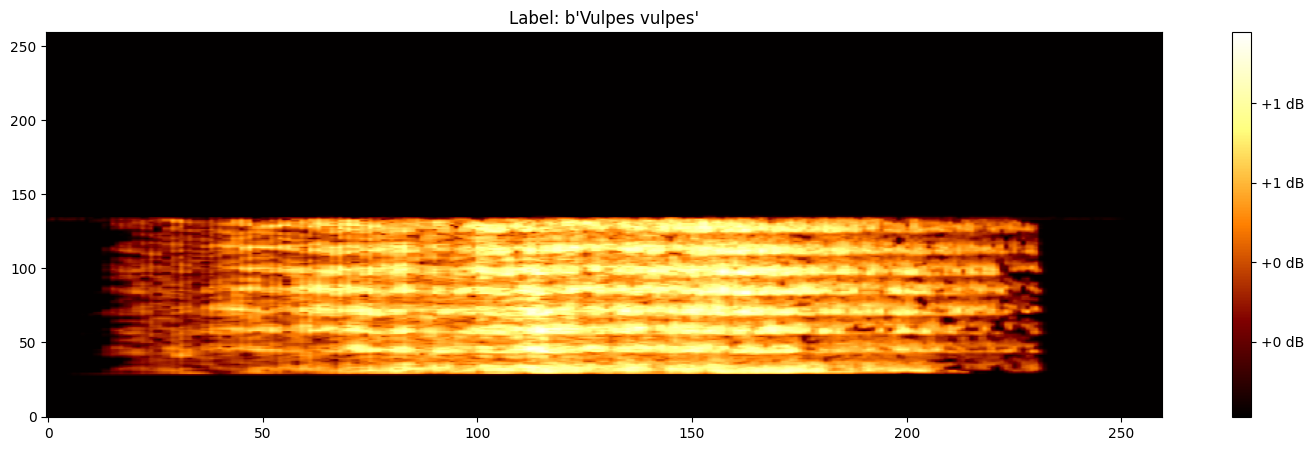

Sample info: (260, 260, 3), 
Label info: () 
b'Vulpes vulpes'


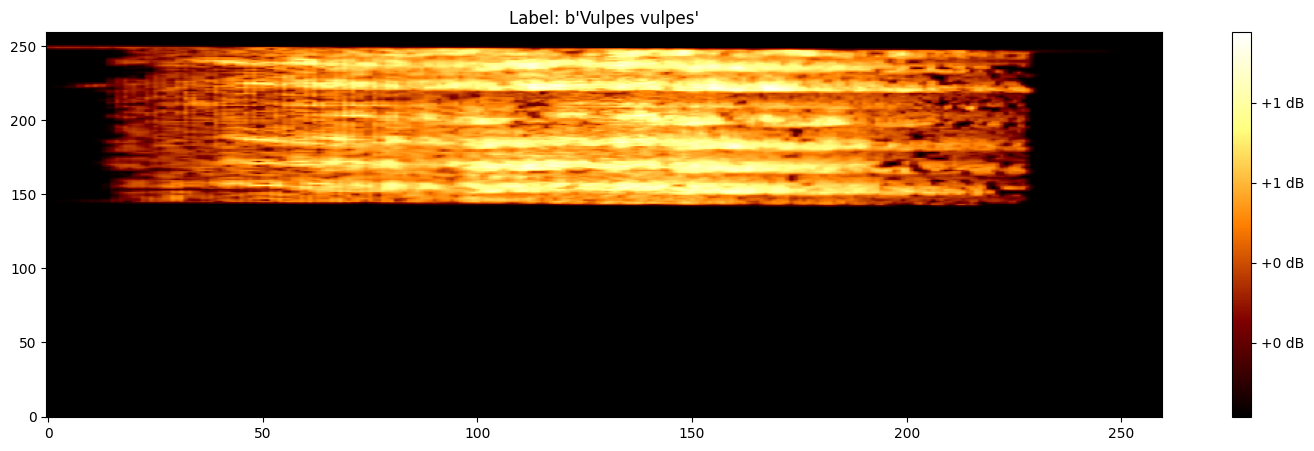

Sample info: (260, 260, 3), 
Label info: () 
b'Vulpes vulpes'


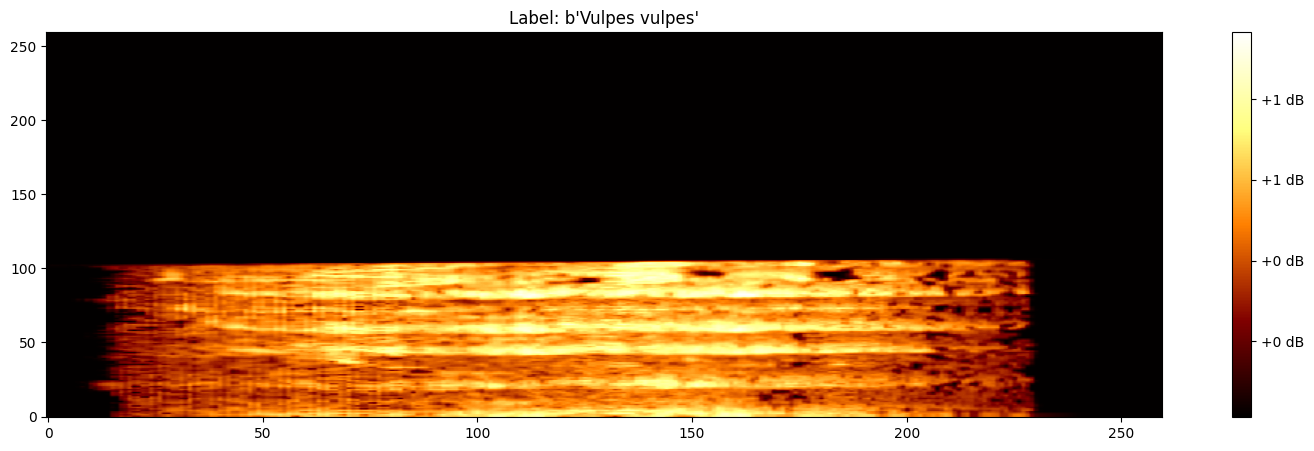

Sample info: (260, 260, 3), 
Label info: () 
b'Vulpes vulpes'


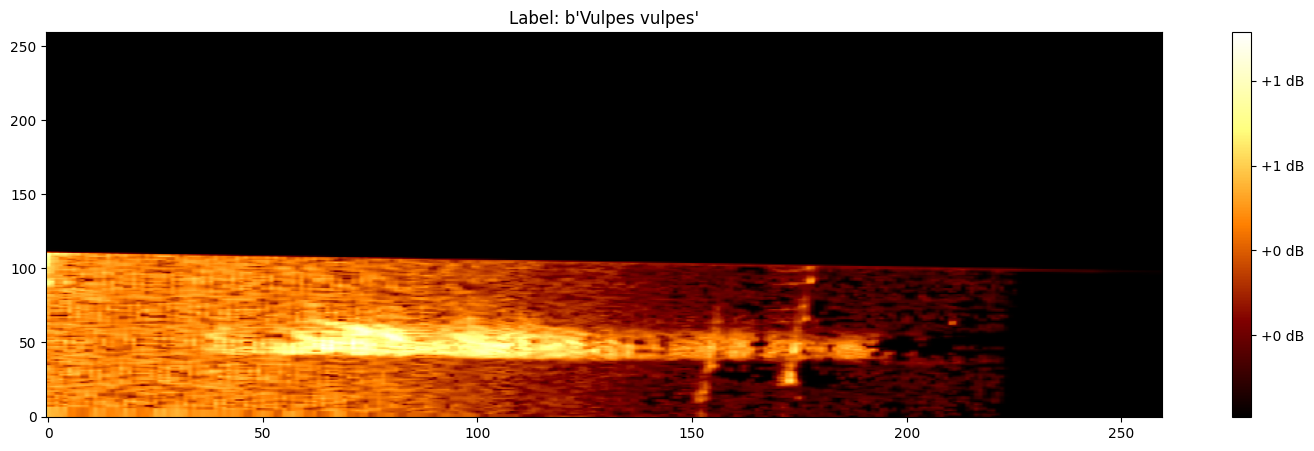

Sample info: (260, 260, 3), 
Label info: () 
b'Vulpes vulpes'


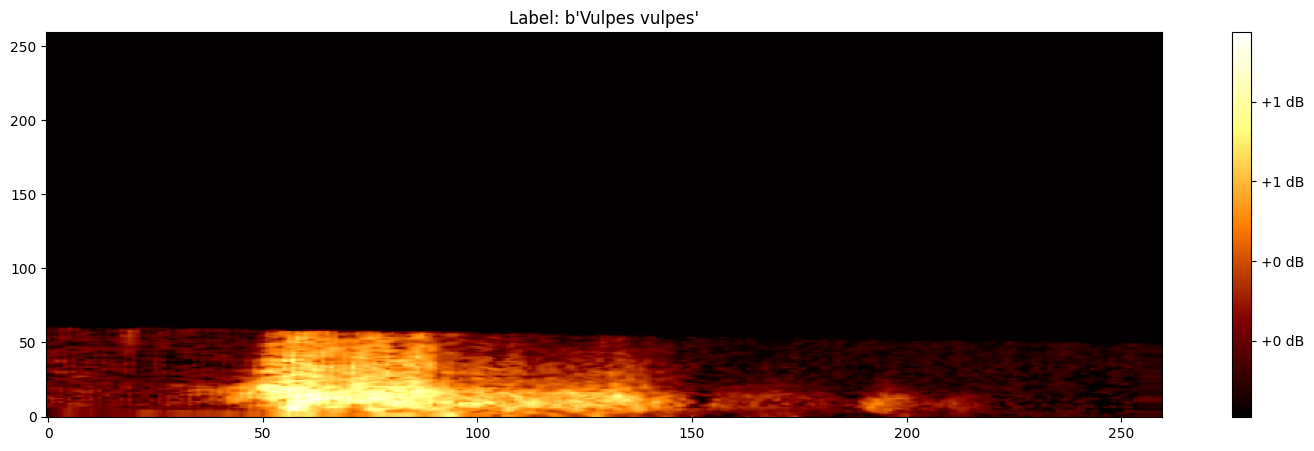

Sample info: (260, 260, 3), 
Label info: () 
b'Vulpes vulpes'


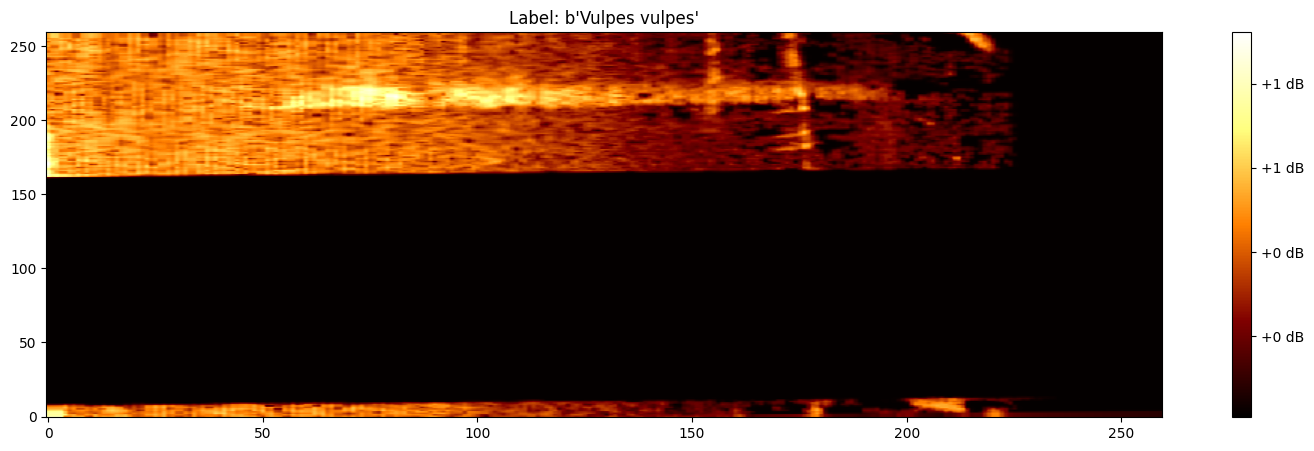

Sample info: (260, 260, 3), 
Label info: () 
b'Vulpes vulpes'


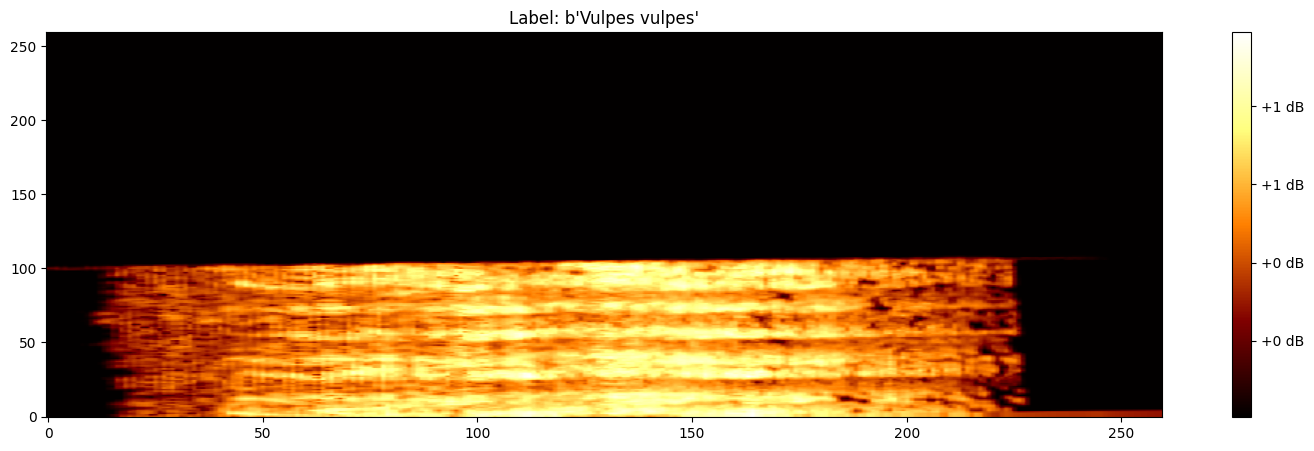

Sample info: (260, 260, 3), 
Label info: () 
b'Vulpes vulpes'


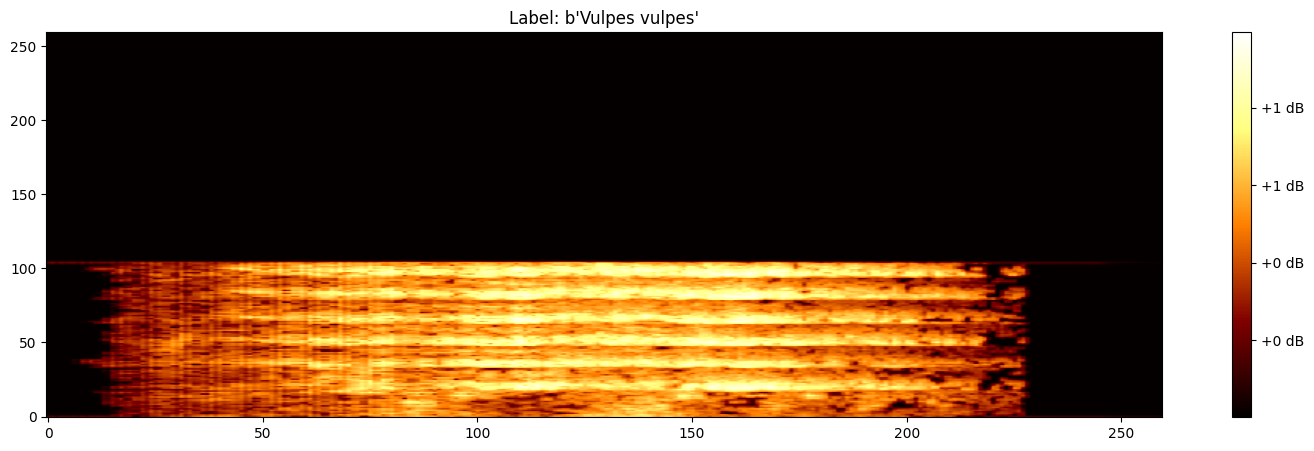

Sample info: (260, 260, 3), 
Label info: () 
b'Vulpes vulpes'


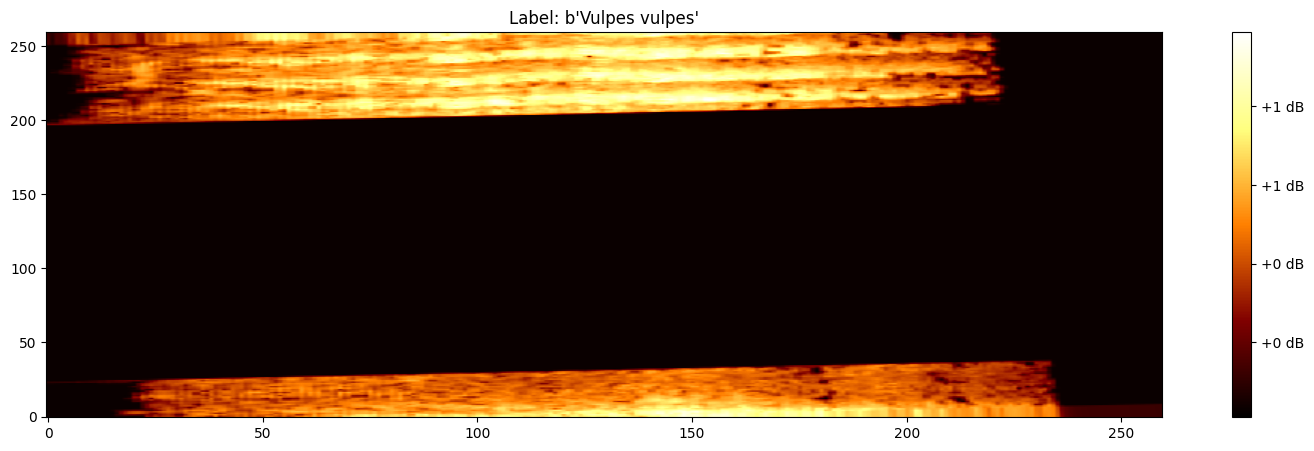

Sample info: (260, 260, 3), 
Label info: () 
b'Vulpes vulpes'


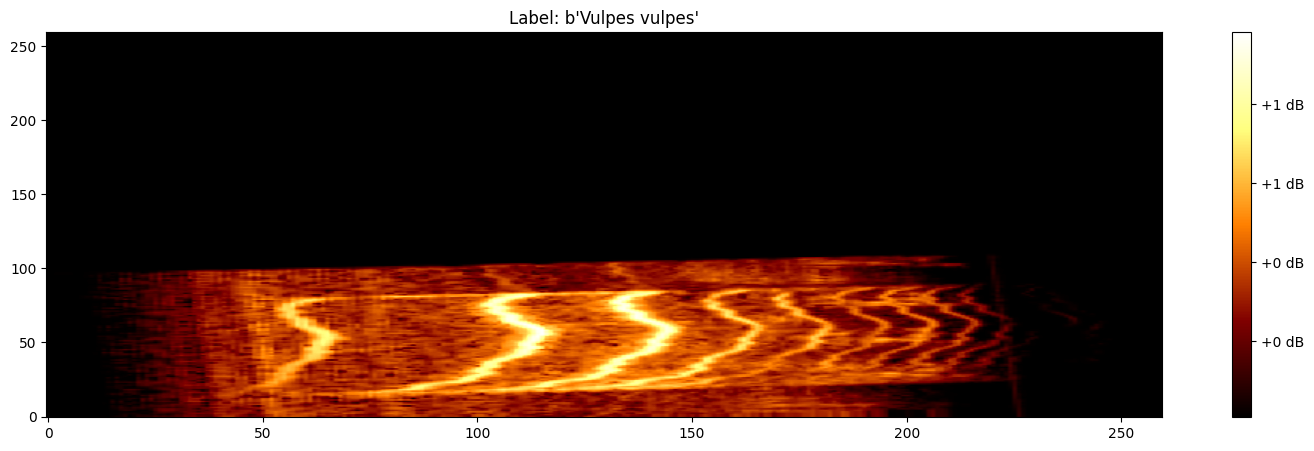

Sample info: (260, 260, 3), 
Label info: () 
b'Vulpes vulpes'


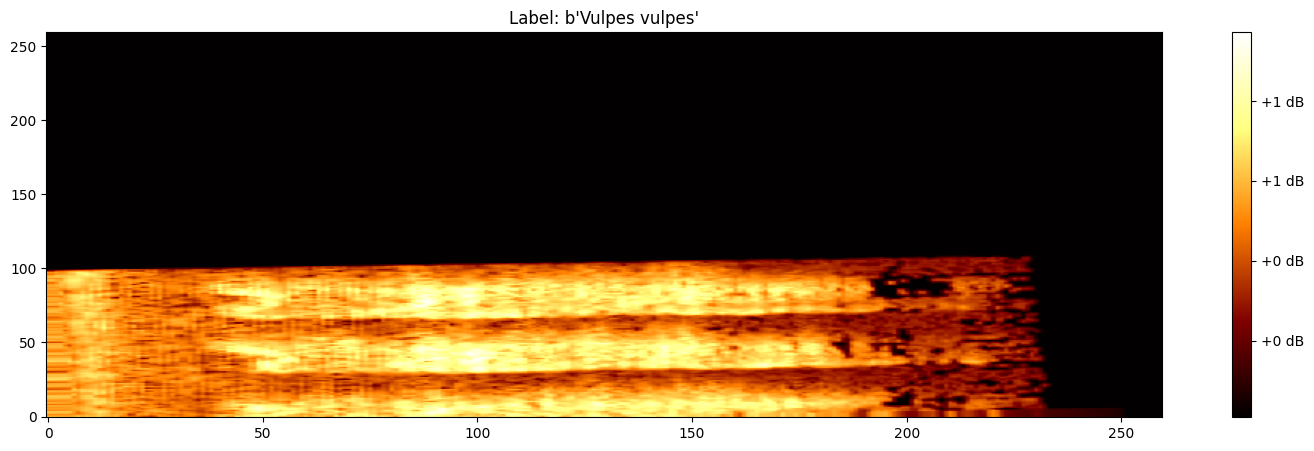

Sample info: (260, 260, 3), 
Label info: () 
b'Vulpes vulpes'


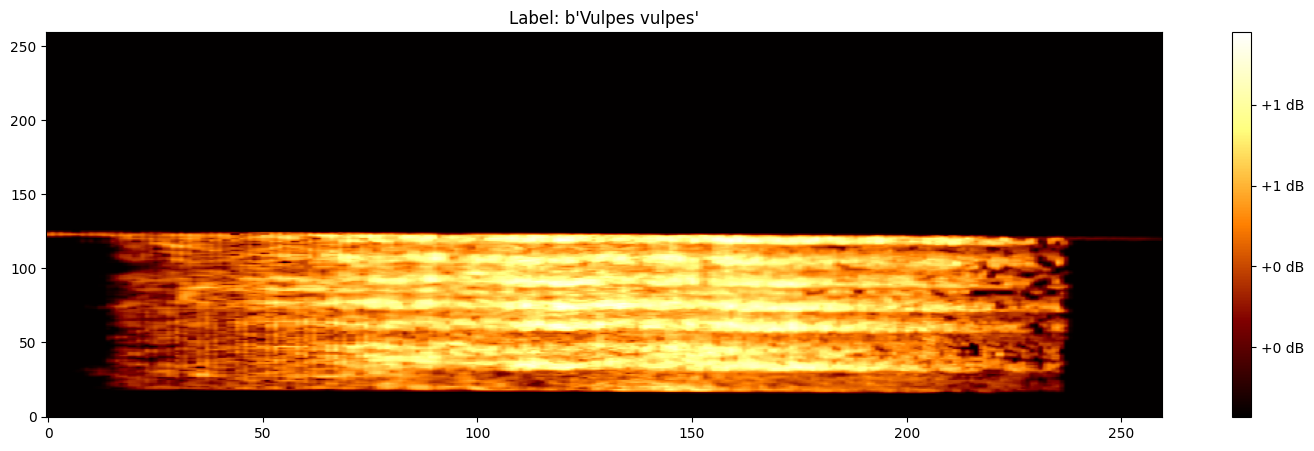

Sample info: (260, 260, 3), 
Label info: () 
b'Vulpes vulpes'


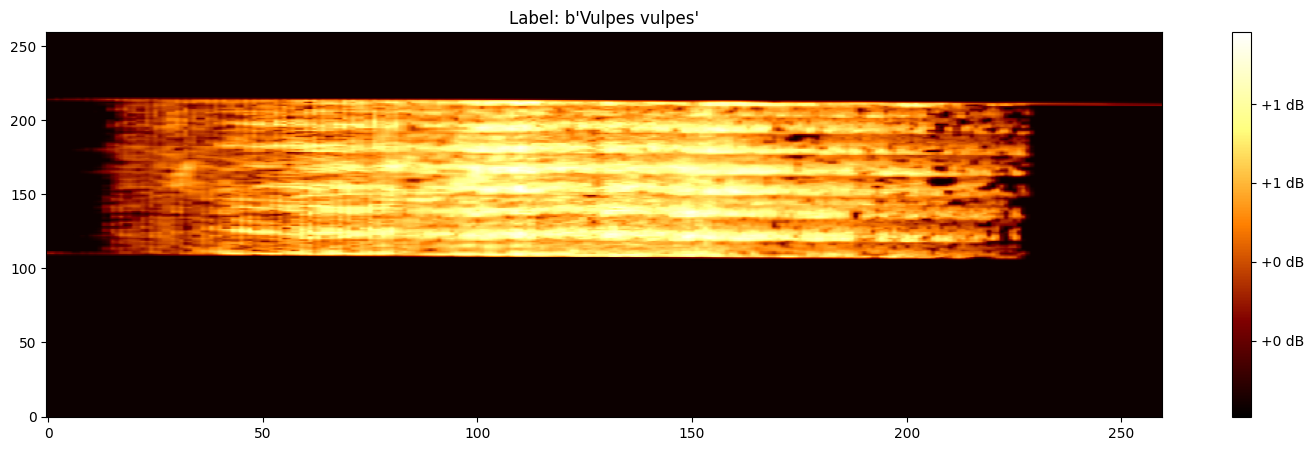

In [143]:
# Show what the pipeline looks like at this stage
for melspectrogram, label in dataset.take(20):  # Loop through individual samples (no batches)
    print(f'Sample info: {melspectrogram.shape}, \nLabel info: {label.shape} \n{label}')
    
    plt.figure(figsize=(18, 5))
    
    # Plot the mel-spectrogram
    plt.imshow(melspectrogram[:,:,0], cmap='afmhot', origin='lower', aspect='auto')
    
    # Title and colorbar
    plt.title('Label: ' + str(label.numpy()))  # Assuming label is a single string
    plt.colorbar(format='%+2.0f dB')
    
    # Show the plot
    plt.show()


In [150]:
import torch
from torch.utils.data import Dataset

class MelSpectrogramDataset(Dataset):
    def __init__(self, mel_spectrograms, labels):
        self.mel_spectrograms = mel_spectrograms
        self.labels = labels

    def __len__(self):
        return len(self.mel_spectrograms)

    def __getitem__(self, idx):
        mel_spectrogram = torch.tensor(self.mel_spectrograms[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return mel_spectrogram, label


In [162]:
import tensorflow as tf
import numpy as np

# Get unique species names (labels) from the TensorFlow label tensor
unique_species = np.unique(all_labels.numpy())

# Create a mapping from species names (strings) to integers
species_to_int = {species.decode('utf-8'): idx for idx, species in enumerate(unique_species)}

print(f"Species to Integer Mapping: {species_to_int}")


Species to Integer Mapping: {'Corvus mellori': 0, 'Rattus norvegicus': 1, 'Vulpes vulpes': 2}


In [163]:
# Convert the TensorFlow label tensor (all_labels) to a NumPy array of integers
integer_labels = np.array([species_to_int[label.decode('utf-8')] for label in all_labels.numpy()])

print(f"Converted Integer Labels: {integer_labels[:10]}")  # Print the first 10 converted labels

Converted Integer Labels: [2 2 2 2 2 2 2 2 2 2]


In [166]:
import torch

# If all_mel_spectrograms and all_labels are TensorFlow tensors, convert them to NumPy
if isinstance(all_mel_spectrograms, tf.Tensor):
    all_mel_spectrograms = all_mel_spectrograms.numpy()

# Convert NumPy arrays to PyTorch tensors
integer_labels_tensor = torch.tensor(integer_labels, dtype=torch.long)

# Assuming you already have mel_spectrograms in a NumPy or PyTorch tensor format
mel_spectrograms_tensor = torch.tensor(all_mel_spectrograms, dtype=torch.float32)

print(f"Mel-spectrograms shape: {mel_spectrograms_tensor.shape}")
print(f"Labels shape: {integer_labels_tensor.shape}")

Mel-spectrograms shape: torch.Size([235, 260, 260, 3])
Labels shape: torch.Size([235])


In [167]:

# Create the PyTorch dataset
full_dataset = MelSpectrogramDataset(mel_spectrograms_tensor, integer_labels_tensor)

# Split the dataset into training, validation, and test sets
train_size = int(0.7 * len(full_dataset))  # 70% for training
val_size = int(0.15 * len(full_dataset))   # 15% for validation
test_size = len(full_dataset) - train_size - val_size  # Remaining for test

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size, test_size])

# Create DataLoader for each dataset
batch_size = 16  # Adjust based on your system
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## Load Model

In [191]:
from torchvision import models, transforms
import torch.nn as nn
#  Load a pre-trained ResNet model from torchvision and set it to evaluation mode
model = models.resnet18(pretrained=True)
model.eval()

# Modify the final fully connected layer to match your number of classes (3 in this case)
num_ftrs = model.fc.in_features  # Get the number of input features to the final layer
model.fc = torch.nn.Linear(num_ftrs, 3)  # Change the output to 3 classes

# Check the modified model
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Hook to Final Conv Layer
To get the feature maps from the last convolutional layer, we will set a forward hook to capture the output of this layer.

In [192]:
# Define a hook class to save the features of the final conv layer
class SaveFeatures:
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
        self.features = None
    
    def hook_fn(self, module, input, output):
        # Save the output (features) of the hooked layer
        self.features = output.data.cpu().numpy()
    
    def remove(self):
        # Remove the hook after we're done
        self.hook.remove()

# Hook into the final convolutional layer of ResNet18 (layer4[1].conv2)
final_conv_layer = model.layer4[1].conv2
activated_features = SaveFeatures(final_conv_layer)


### Perform Forward Pass to Get Predictions
We perform a forward pass through the network to obtain the model's predictions and save the activations of the final convolutional layer.

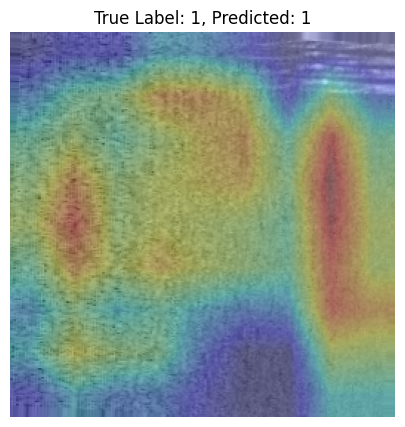

In [206]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2

def generate_cam(feature_maps, class_weights, class_idx):
    """
    Generate CAM by multiplying the class weights with feature maps.
    """
    _, num_channels, height, width = feature_maps.shape
    cam = np.zeros((height, width), dtype=np.float32)

    for i in range(num_channels):
        cam += class_weights[class_idx, i] * feature_maps[0, i, :, :]

    cam = np.maximum(cam, 0)
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)

    return cam

# Get the first batch from the train_loader
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Permute the dimensions from [batch_size, height, width, channels] to [batch_size, channels, height, width]
images = images.permute(0, 3, 1, 2)




# Select one image from the batch (first one)
image = images[0].unsqueeze(0)  # Add batch dimension back

# Perform a forward pass through the model to get predictions
output = model(image)

# Get the predicted class (the class with the highest output score)
_, pred_class = torch.max(output, 1)

# Get the weights of the final fully connected (fc) layer
fc_weights = model.fc.weight.data.cpu().numpy()

# Generate CAM for the predicted class
cam = generate_cam(activated_features.features, fc_weights, pred_class.item())

# Resize the CAM to match the original mel-spectrogram size
cam_resized = cv2.resize(cam, (image.shape[2], image.shape[3]))

true_label = labels[0].item()

# Plot the CAM over the mel-spectrogram
plt.figure(figsize=(18, 5))
plt.imshow(image.squeeze().permute(1, 2, 0).numpy(), cmap='gray', alpha=1)  # Show the mel-spectrogram in grayscale
plt.imshow(cam_resized, cmap='jet', alpha=0.3)  # Overlay the CAM on top
plt.title(f"True Label: {true_label}, Predicted: {pred_class.item()}")
plt.axis('off')
plt.show()


Now we see how CAM could show where the weights are in the CNN. This can be useful to interpret the model's prediction.
Red/Yellow regions show high activation, thus this part of the image has the most influence. The blue shows low activation thus less influence. 